In [ ]:
import logging
import os
import sys
import math
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').disabled = True
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from run_training import _build_model, _find_py_file

In [ ]:
logging.basicConfig(level=1, format='[%(asctime)s %(levelname)s] %(message)s')
Option = namedtuple("MyStruct", "input model name folds batch_size epochs")
                    #structure learning_rate regularizer epochs")
args = Option(
    input='data/train.h5',
    model='share/reference_number.py',
    name='NumberNetworkKFOLD',
    folds=10,
    batch_size=60,
    epochs=20,
    #learning_rate=0.0001,
    #regularizer=0.0001,
)

path = _find_py_file(args.model)

# K-Fold Validation
## Load and Split Data

In [ ]:
logging.info(f'Loading data from {args.input}')

with h5.File(args.input, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

labels = ['1particle', '2particle', '3particle']

In [ ]:
logging.info('Building model from %s', path)
model, compile_args, fit_args, params = _build_model(path, data_x, data_y)

In [ ]:
#model.summary()

In [ ]:
#keras.utils.plot_model(model)

In [ ]:
#FOR ITERATIVE TESTING QUICKER
#data_x = data_x[:5000]
#data_y = data_y[:5000]

In [ ]:
models = []
#histories = []
#preds = []
#reals = []
fpr = {}
tpr = {}
auc1 = {}
acc_per_fold = []
loss_per_fold = []

# DATA COMES PRESHUFFLED NOW

#dont forget to shuffle
#data = np.concatenate([data_x, data_y], axis=1)
#rng = np.random.default_rng(seed=42)
#rng.shuffle(data)

#data_x = data[:, 0:data_x.shape[1]]
#data_y = data[:, data_x.shape[1]:data.shape[1]]

K-Fold Split Indices
kfold = KFold(n_splits=args.folds)
splits = kfold.split(data_x,data_y)

#
# To Do: Barrel and Endcap Layer Seperation
# Index of data_x in axis=1 corresponds to
# IBL: array[56] ==0 && array[57]==0
# Barrel: array[56] >0 && array[57]==0
# Endcap: array[57]!=0
#

## Training and Validation

In [16]:
fold_no = 0
with h5.File(f'output/{args.name}.h5', 'w'):
    logging.info(f'output/{args.name}.h5 created/emptied')

for train, test in splits:
    fold_no += 1
    logging.info(f'Building model for fold {fold_no} from {path}...')
    model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
    compile_args['metrics']=['accuracy']
    fit_args['batch_size']=args.batch_size
    fit_args['validation_split'] = 0.1
    fit_args['epochs'] = args.epochs
    fit_args['callbacks'] = [keras.callbacks.TerminateOnNaN(),
                             keras.callbacks.ModelCheckpoint(args.name + str(fold_no) + '.h5', save_best_only=True,verbose=1)]
                             #keras.callbacks.CSVLogger('output/'+args.name+str(fold_no)+'.csv')]
    logging.info(f'Compiling for fold {fold_no} ...')
    model.compile(**compile_args)

    logging.info(f'Training for fold {fold_no} ...')
    history = model.fit(data_x[train], data_y[train], **fit_args)
    
    logging.info(f'Testing on fold {fold_no} ...')
    scores = model.evaluate(data_x[test], data_y[test])
    
    logging.info(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])
    
    logging.info(f'Calculating inference for fold {fold_no} ...')
    y_pred = model.predict(data_x[test])
    #preds.append(y_pred)
    #reals.append(data_y[test])
    
    for i, label in enumerate(labels):
        fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'], threshold = roc_curve(data_y[test][:,i], y_pred[:,i])
        auc1[f'{label}_{fold_no}'] = auc(fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'])
        
    logging.info(f'Writing fit history to output/{args.name}.h5')
    with h5.File(f'output/{args.name}.h5', 'a') as hfile:
        for key, val in history.history.items():
            hfile.create_dataset(key+'_'+str(fold_no), data=np.array(val))
        for label in labels:
            hfile.create_dataset(f'{label}_{fold_no}_fpr', data=fpr[f'{label}_{fold_no}'])
            hfile.create_dataset(f'{label}_{fold_no}_tpr', data=tpr[f'{label}_{fold_no}'])
            hfile.create_dataset(f'{label}_{fold_no}_auc', data=auc1[f'{label}_{fold_no}'])
    models.append(model)

logging.info('Done training!')


oss: 0.7447 - accuracy: 0.7317
Epoch 00003: val_loss improved from 0.78250 to 0.77060, saving model to NumberNetworkKFOLD8.h5
68/68 [==============================] - 0s 4ms/step - loss: 0.7448 - accuracy: 0.7311 - val_loss: 0.7706 - val_accuracy: 0.7111
Epoch 4/20
57/68 [========================>.....] - ETA: 0s - loss: 0.7360 - accuracy: 0.7284
Epoch 00004: val_loss improved from 0.77060 to 0.75850, saving model to NumberNetworkKFOLD8.h5
68/68 [==============================] - 0s 4ms/step - loss: 0.7317 - accuracy: 0.7311 - val_loss: 0.7585 - val_accuracy: 0.7111
Epoch 5/20
62/68 [==========================>...] - ETA: 0s - loss: 0.7162 - accuracy: 0.7298
Epoch 00005: val_loss improved from 0.75850 to 0.73119, saving model to NumberNetworkKFOLD8.h5
68/68 [==============================] - 0s 3ms/step - loss: 0.7133 - accuracy: 0.7311 - val_loss: 0.7312 - val_accuracy: 0.7111
Epoch 6/20
58/68 [========================>.....] - ETA: 0s - loss: 0.6814 - accuracy: 0.7333
Epoch 00006: va

"\nfpr_dict = {}\ntpr_dict = {}\nfor i,label in enumerate(labels):\n    #print(f'{label}_{k+1}')\n    fpr_dict[label] = np.array([])\n    tpr_dict[label] = np.array([])\n    for k in range(fold_no):\n        #print(k)\n        fpr_dict[label] = np.concatenate([fpr_dict[label], fpr[label+f'_{k+1}']], axis=0)\n        tpr_dict[label] = np.concatenate([tpr_dict[label], tpr[label+f'_{k+1}']], axis=0)\n"

In [5]:
with h5.File('output/NumberNetworkKFOLD.h5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['1particle_10_auc', '1particle_10_fpr', '1particle_10_tpr', '1particle_1_auc', '1particle_1_fpr', '1particle_1_tpr', '1particle_2_auc', '1particle_2_fpr', '1particle_2_tpr', '1particle_3_auc', '1particle_3_fpr', '1particle_3_tpr', '1particle_4_auc', '1particle_4_fpr', '1particle_4_tpr', '1particle_5_auc', '1particle_5_fpr', '1particle_5_tpr', '1particle_6_auc', '1particle_6_fpr', '1particle_6_tpr', '1particle_7_auc', '1particle_7_fpr', '1particle_7_tpr', '1particle_8_auc', '1particle_8_fpr', '1particle_8_tpr', '1particle_9_auc', '1particle_9_fpr', '1particle_9_tpr', '2particle_10_auc', '2particle_10_fpr', '2particle_10_tpr', '2particle_1_auc', '2particle_1_fpr', '2particle_1_tpr', '2particle_2_auc', '2particle_2_fpr', '2particle_2_tpr', '2particle_3_auc', '2particle_3_fpr', '2particle_3_tpr', '2particle_4_auc', '2particle_4_fpr', '2particle_4_tpr', '2particle_5_auc', '2particle_5_fpr', '2particle_5_tpr', '2particle_6_auc', '2particle_6_fpr', '2particle_6_tpr', '2particle

## Plotting and Evaluation

In [11]:

folds = 10
fpr_LG = [0]*len(labels)
tpr_LG = [0]*len(labels)
auc_LG = [0]*len(labels)

fpr_list = [[0]*(folds) for i in range(len(labels))]
tpr_list = [[0]*(folds) for i in range(len(labels))]
auc_list = [[0]*(folds) for i in range(len(labels))]

model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
compile_args['metrics']=['accuracy']
model.compile(**compile_args)
model.load_weights('modelWeights/LGNumberNetworkModel.h5')

#scores = model.evaluate(data_x[:5000], data_y[:5000])
y_pred = model.predict(data_x)

for i, label in enumerate(labels):
    fpr_LG[i], tpr_LG[i], threshold = roc_curve(data_y[:][:,i], y_pred[:,i])
    auc_LG[i] = auc(fpr_LG[i], tpr_LG[i])

print(f'LG complete')

for i in range(folds):
    
    model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
    compile_args['metrics']=['accuracy']
    model.compile(**compile_args)
    model.load_weights(f'modelWeights/NumberNetworkKFOLD{i+1}.h5')
    y_pred = model.predict(data_x)

    for j, label in enumerate(labels):
        fpr_list[j][i], tpr_list[j][i], threshold = roc_curve(data_y[:][:,j], y_pred[:,j])
        auc_list[j][i] = auc(fpr_list[j][i], tpr_list[j][i])
        
    print(f'{i} fold complete')


LG complete
0 fold complete
1 fold complete
2 fold complete
3 fold complete
4 fold complete
5 fold complete
6 fold complete
7 fold complete
8 fold complete
9 fold complete


# ROC Curves

[2020-07-09 02:01:11,282 DEBUG] Assigning font /b'F1' = 'C:\\ProgramData\\Anaconda3\\envs\\MDNtraining_TF\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
[2020-07-09 02:01:11,584 DEBUG] Assigning font /b'F2' = 'C:\\ProgramData\\Anaconda3\\envs\\MDNtraining_TF\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf'
[2020-07-09 02:01:11,586 DEBUG] Embedding font C:\ProgramData\Anaconda3\envs\MDNtraining_TF\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf.
[2020-07-09 02:01:11,587 DEBUG] Writing TrueType font.
[2020-07-09 02:01:11,599 DEBUG] Embedding font C:\ProgramData\Anaconda3\envs\MDNtraining_TF\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
[2020-07-09 02:01:11,601 DEBUG] Writing TrueType font.


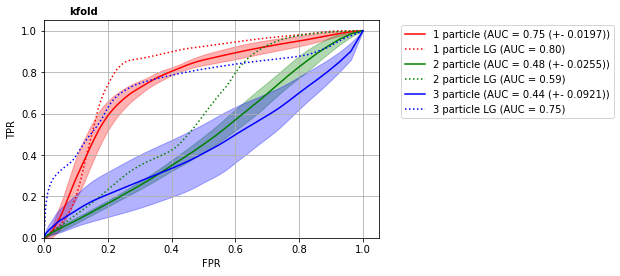

In [19]:
def kfoldRoc(infile, labels, name="", outdir="", fprl=None, tprl=None, aucl=None):

    folds = 10
    npoints = 200
    base_fpr = np.exp(np.linspace(math.log(0.0005), 0., npoints))
    colors = ["r", "g", "b"]
    avg_tpr = {}
    plus_tpr = {}
    minus_tpr = {}

    if (fprl==None):
        fprl = [[0]*(folds) for i in range(len(labels))]
        tprl = [[0]*(folds) for i in range(len(labels))]
        aucl = [[0]*(folds) for i in range(len(labels))]
        with h5.File(infile, 'r') as hfile:
            for i, label in enumerate(labels):
                for j in range(folds):
                    fprl[i][j] = hfile[f'{label}_{j+1}_fpr'][()]
                    tprl[i][j] = hfile[f'{label}_{j+1}_tpr'][()]
                    aucl[i][j] = hfile[f'{label}_{j+1}_auc'][()]
    fpr_list = np.array(fprl)
    tpr_list = np.array(tprl)
    auc_list = np.array(aucl)

    plt.figure()

    for i, particle in enumerate(labels):
        tpr_array = np.array([])
        for j in range(folds):
            tpr_interpolated = np.interp(base_fpr, fpr_list[i][j], tpr_list[i][j])
            tpr_interpolated = tpr_interpolated.reshape((1,npoints))
            tpr_array = np.concatenate([tpr_array, tpr_interpolated], axis=0) if tpr_array.size else tpr_interpolated
        mean_tpr = np.mean(tpr_array, axis=0)
        rms_tpr = np.std(tpr_array, axis=0)
        plus_tpr[particle] = np.minimum(mean_tpr+rms_tpr, np.ones(npoints))
        minus_tpr[particle] = np.maximum(mean_tpr-rms_tpr,np.zeros(npoints))
        avg_tpr[particle] = mean_tpr

        plt.plot(base_fpr, avg_tpr[particle], color=colors[i], label=f'{i+1} particle (AUC = {np.mean(auc_list[i][()]):.2f} (+- {np.std(auc_list[i][()]):.4f}))')
        plt.fill_between(base_fpr, minus_tpr[particle], plus_tpr[particle], color=colors[i], alpha=0.3)

        plt.plot(fpr_LG[i], tpr_LG[i], color=colors[i], linestyle=':', label=f'{i+1} particle LG (AUC = {auc_LG[i]:.2f})')

    #plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    #plt.semilogx()
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim([0, 1.05])
    plt.ylim(0,1.05)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{name}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.savefig(f'{outdir}{name}_ROC.pdf')
    plt.show()
    plt.close()
    
    
labels = ['1particle', '2particle', '3particle']
kfoldRoc(f'output/{args.name}.h5', labels, "kfold", "output/", fpr_list, tpr_list, auc_list)

In [17]:
def learningCurves(infile, outdir=""):

    folds = 10
    losses = [[0]*(folds) for i in range(2)]

    with h5.File(infile, 'r') as hfile:
        for i in range(folds):
            losses[0][i] = hfile[f'loss_{i+1}'][()]
            losses[1][i] = hfile[f'val_loss_{i+1}'][()]

    for i in range(len(losses)):
        for j in range(folds):
            plt.plot(losses[i][j], label= ('val_' if i else '') + f'loss for {j} fold')

    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    plt.semilogx()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.xlim([-0.05, 20])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'loss',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig(f'{outdir}loss.pdf')
    plt.close()

In [18]:
learningCurves(f'output/{args.name}.h5', "output/")

[2020-07-09 01:58:12,794 DEBUG] Assigning font /b'F1' = 'C:\\ProgramData\\Anaconda3\\envs\\MDNtraining_TF\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
[2020-07-09 01:58:13,001 DEBUG] Assigning font /b'F2' = 'C:\\ProgramData\\Anaconda3\\envs\\MDNtraining_TF\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf'
[2020-07-09 01:58:13,003 DEBUG] Embedding font C:\ProgramData\Anaconda3\envs\MDNtraining_TF\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf.
[2020-07-09 01:58:13,006 DEBUG] Writing TrueType font.
[2020-07-09 01:58:13,018 DEBUG] Embedding font C:\ProgramData\Anaconda3\envs\MDNtraining_TF\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
[2020-07-09 01:58:13,026 DEBUG] Writing TrueType font.


In [21]:
print('---Average scores---')
print('Score per fold')
for i in range(0,len(acc_per_fold)):
    print(f'Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {acc_per_fold[i]:.2f}%')
print('--------------------')
print('Average scores for all folds:')
print(f'Accuracy: {np.mean(acc_per_fold):.2f} (+- {np.std(acc_per_fold):.4f})')
print(f'Loss: {np.mean(loss_per_fold):.4f} (+- {np.std(loss_per_fold):.4f})')
print('---Average AUC------')
for label in labels:
    for i in range(fold_no-1):
        print(f'Fold {i+1} - {label} - AUC: {auc1[label][i]*100:.2f}')
        
print('--------------------')
print('Average AUC for all folds:')
for label in labels:
    print(f'{label} - AUC: {np.mean(auc1[label]):.2f} (+- {np.std(auc1[label]):.4f})')

---Average scores---
Score per fold
Fold 1 - Loss: 0.0009 - Accuracy: 100.00%
Fold 2 - Loss: 0.0009 - Accuracy: 100.00%
Fold 3 - Loss: 0.0009 - Accuracy: 100.00%
Fold 4 - Loss: 0.0009 - Accuracy: 100.00%
Fold 5 - Loss: 0.0009 - Accuracy: 100.00%
Fold 6 - Loss: 0.0008 - Accuracy: 100.00%
Fold 7 - Loss: 0.0008 - Accuracy: 100.00%
Fold 8 - Loss: 0.0008 - Accuracy: 100.00%
Fold 9 - Loss: 0.0009 - Accuracy: 100.00%
Fold 10 - Loss: 0.0009 - Accuracy: 100.00%
--------------------
Average scores for all folds:
Accuracy: 100.00 (+- 0.0000)
Loss: 0.0009 (+- 0.0000)
---Average AUC------
Fold 1 - 1particle - AUC: nan
Fold 2 - 1particle - AUC: nan
Fold 3 - 1particle - AUC: nan
Fold 4 - 1particle - AUC: nan
Fold 5 - 1particle - AUC: nan
Fold 6 - 1particle - AUC: nan
Fold 7 - 1particle - AUC: nan
Fold 8 - 1particle - AUC: nan
Fold 1 - 2particle - AUC: nan
Fold 2 - 2particle - AUC: nan
Fold 3 - 2particle - AUC: nan
Fold 4 - 2particle - AUC: nan
Fold 5 - 2particle - AUC: nan
Fold 6 - 2particle - AUC: n